In [3]:
 import numpy as np
# hỗ trợ cho việc tính toán các mảng nhiều chiều
import pandas as pd
# thao tác và phân tích dữ liệu
import yfinance as yf
import matplotlib.pyplot as plt
# vẽ biểu đồ, đồ thị
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
# hàm đưa dữ liệu về giá trị (0,1)
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Gộp dữ liệu vào chuyển thành dữ liệu time series
from keras.models import Sequential
# khởi tạo mạng neurol
from keras.layers import Dense
# một lớp để chuyển dữ liệu từ lớp input vào model ????
from keras.layers import LSTM
import datetime as dt
# mô hình LSTM 
from keras.layers import Dropout
# giúp bỏ bớt các node, giúp lọc lại những node có thông tin cần thiết 
from tensorflow import keras
# from datetime import datatime
plt.style.use("fivethirtyeight")
# style của thư viện mathplotlib
import warnings
warnings.filterwarnings("ignore")
# Những thư viện cần dùng



2025-03-15 16:33:40.163758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 16:33:40.164352: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-15 16:33:40.166411: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-15 16:33:40.172824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742031220.184486   37143 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742031220.18

In [4]:
Macophieu = "VDS.VN"
prop = 'Close'
companyName = 'VDS.VN'
tickerData = yf.Ticker(Macophieu) 
start ='2014-01-01'
end ='2024-12-31'
# tickerDf = tickerData.history(period='1d', start=start, end=end)
tickerDf = tickerData.history(period='1d', start=start, end=end)
#lấy giá trị từ ngày đến những ngày trước đó
data = tickerDf
data.reset_index(inplace=True)
# đánh số thứ tự lại cho data thay cho cột ngày
print(data)



                          Date          Open          High           Low  \
0    2014-01-07 00:00:00+07:00   1767.213745   1767.213745   1660.109863   
1    2014-01-08 00:00:00+07:00   1660.109863   1820.765747   1660.109863   
2    2014-01-09 00:00:00+07:00   1874.317627   1874.317627   1767.213745   
3    2014-01-10 00:00:00+07:00   1713.661865   1820.765747   1713.661865   
4    2014-01-13 00:00:00+07:00   1820.765747   1874.317627   1820.765747   
...                        ...           ...           ...           ...   
2577 2024-12-24 00:00:00+07:00  20950.000000  20950.000000  20150.000000   
2578 2024-12-25 00:00:00+07:00  20800.000000  21400.000000  20350.000000   
2579 2024-12-26 00:00:00+07:00  20950.000000  20950.000000  20450.000000   
2580 2024-12-27 00:00:00+07:00  20450.000000  21000.000000  20300.000000   
2581 2024-12-30 00:00:00+07:00  20850.000000  21350.000000  20800.000000   

             Close   Volume  Dividends  Stock Splits  
0      1660.109863    19605     

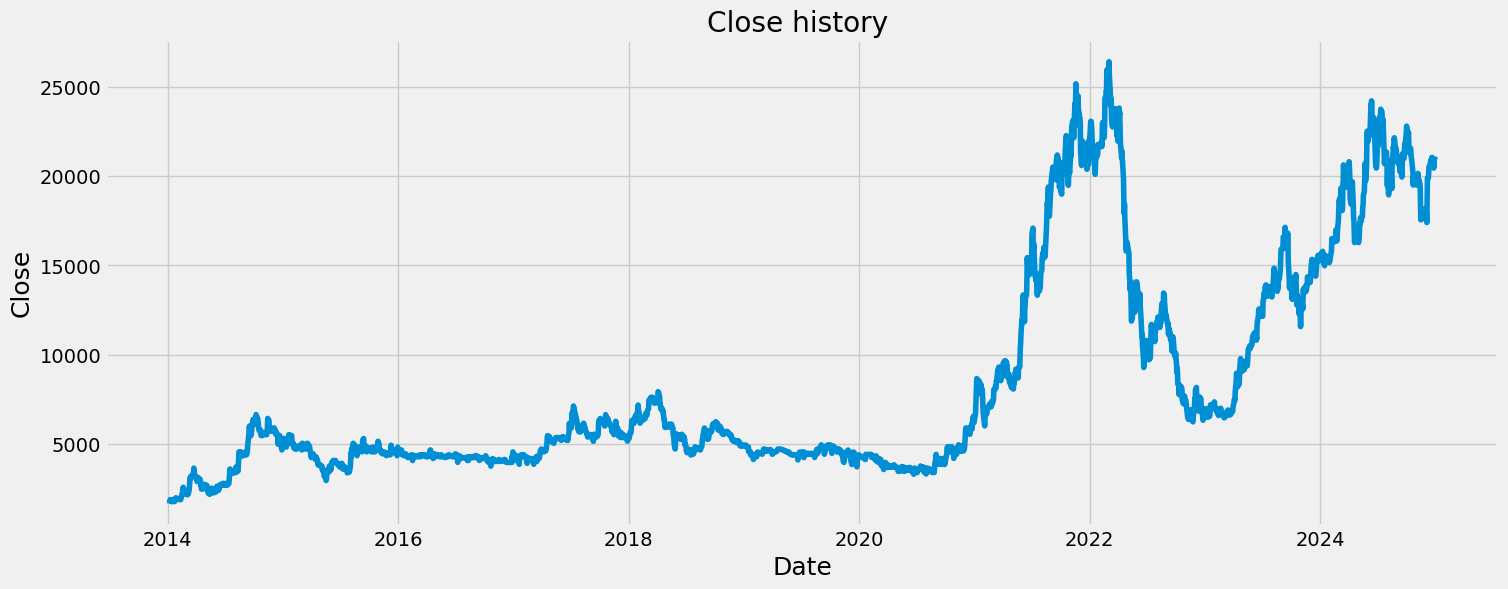

In [7]:
plt.figure(figsize = (16,6))
plt.plot(data['Date'],data[prop])
plt.title( prop + " history ")
plt.xlabel('Date', fontsize = 18)
plt.ylabel(f'{prop}', fontsize = 18)
plt.show()

In [9]:
data_end = int(np.floor(0.8*(data.shape[0])))
# lấy cái mốc là data_end theo tử lệ 2:8
train = data[0:data_end][prop] 
# lấy 80% là giá mỏ cho tập train
test = data[data_end:][prop]
# lấy 20% data là giá mở cho tập test
date_test = data[data_end:]['Date']
# lấy 20% là ngày trùng vs tập test 

In [11]:

train = train.values.reshape(-1)
test = test.values.reshape(-1)
date_test = date_test.values.reshape(-1)

In [13]:
def get_data(train,test,time_step,num_predict,date):
  x_train= list()
  y_train = list()
  x_test = list()
  y_test = list()
  date_test= list()
    
  for i in range(0,len(train) - time_step - num_predict):
    x_train.append(train[i:i+time_step])
    y_train.append(train[i+time_step:i+time_step+num_predict])
  for i in range(0, len(test) - time_step - num_predict):
    x_test.append(test[i:i+time_step])
    y_test.append(test[i+time_step:i+time_step+num_predict])
    date_test.append(date[i+time_step:i+time_step+num_predict])


  return np.array(x_train, dtype=np.float32), np.array(y_train, dtype=np.float32), \
       np.array(x_test, dtype=np.float32), np.array(y_test, dtype=np.float32), \
       np.array([str(d) for d in date_test], dtype=object) 

In [15]:

# gọi hàm dựa data vào mảng train test time_step num_predict, date_test
x_train, y_train, x_test, y_test, date_test = get_data(train,test,30,1, date_test)
# chuyển về dạng ma trận đưa vào minmaxscaler()
x_train = x_train.reshape(-1,30)
x_test = x_test.reshape(-1,30)

# dua ve 0->1 cho tap train
scaler = MinMaxScaler()

# gọi hàm scaler để nén hoặc giải nén data về khoảng (0,1) để máy hiểu góp phần tăng tốc độ máy học
# fit_transform nén data lại cho model cho 4 ma trận x, y_train x,y test
x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test)

In [17]:

# chuyển về dạng ma trận đưa vào keras() thêm một chiều thứ 3 để có bias => để thành ma trận 3D cho phù hợp với bài toán

# Reshape lai cho x_train
x_train = x_train.reshape(-1,30,1)
y_train = y_train.reshape(-1,1)

#reshape lai cho test
x_test = x_test.reshape(-1,30,1)
y_test = y_test.reshape(-1,1)
date_test = date_test.reshape(-1,1)
     

In [19]:
# 1 lớp là giá của 30 ngày (n_input)
# n_feature số lượng cột ở đây là giá mở
# return_sequences trả về chuỗi 

n_input = 30
n_features = 1

# Khởi tạo mạng neurol
model = Sequential()
model.add(LSTM(units = 50, input_shape=(n_input, n_features), return_sequences=True))
# trả về dạng chuỗi để đưa vào layer tiếp theo
# true thì nó trả về chuỗi các hidden state false thì trả về output
model.add(Dropout(0.3))
# lớp thứ hai
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.3))
# lớp thứ ba
model.add(LSTM(units = 50))
model.add(Dropout(0.3))
# đưa về lớp cuối cùng 1 node
model.add(Dense(1))
# đưa vào xác định hàm lỗi(loss function) 'mse' và hàm tối ưu(vd gradient) 'adam' 
model.compile(optimizer ='adam', loss ='mse')

2025-03-15 16:33:47.796941: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, epochs=200, validation_split=0.2, 
          verbose=1, batch_size=30, callbacks=[early_stopping])


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0030 - val_loss: 0.0099
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 6.1763e-04 - val_loss: 0.0073
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 4.1782e-04 - val_loss: 0.0148
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.4489e-04 - val_loss: 0.0218
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 4.6612e-04 - val_loss: 0.0124
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 3.7171e-04 - val_loss: 0.0034
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 3.4767e-04 - val_loss: 0.0044
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.1527e-04 - val_loss: 0.0027
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.7079e-04 - val_loss: 0.0028
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.4901e-04 - val_loss: 0.0028
Epoch 11/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 2.5017e-04 - val_loss: 0.0024
Epoch 12/200

In [ ]:
model.save(f'/home/phung/jnotebook/source/Tuan9/model/{Macophieu}_{prop}.keras')


In [ ]:
model = keras.models.load_model(f'/home/phung/jnotebook/source/Tuan9/model/{Macophieu}_{prop}.keras')
test_output = model.predict(x_test)
# lấy tập x_test cho vào model ra test_output là data dự đoán

# giải nén dữ liệu từ (0,1) ra giá thực tế
test_1 = scaler.inverse_transform(test_output)
test_2 =scaler.inverse_transform(y_test)
 # Chuyển sang dạng datetime




In [ ]:

plt.figure(figsize=(20,12))
# plt.plot(date_test, test_2, label="Actual Price", color='blue')
# plt.plot(date_test, test_1, label="Predicted Price", color='red')

# plt.plot( test_1[30:], color='r')
# plt.plot( test_2[30:], color='b')
plt.plot(range(len(test_1[30:])), test_1[30:], color='r', label="Predicted Price")
plt.plot(range(len(test_2[30:])), test_2[30:], color='b', label="Actual Price")
plt.xlabel("Date", fontsize=14)

plt.ylabel(f"{prop} Price", fontsize=14)
plt.title(f"{companyName} {prop} Price Prediction", fontsize=16)
plt.legend()

plt.show()

